In [1]:
import outlaw.nb_util as nb_util
nb_util.setup_nb()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

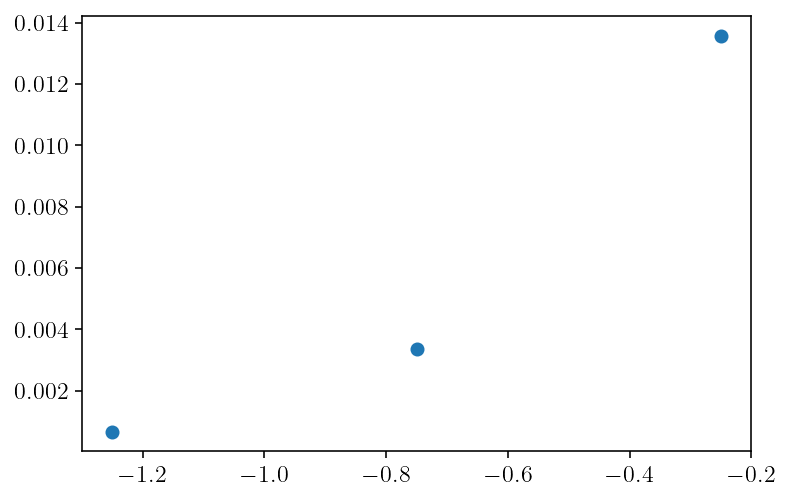

In [4]:
npts = 3
mu = np.linspace(-1, 0, npts)
stepsize = mu[1] - mu[0]
mu = mu - stepsize/2
power = 1 - scipy.stats.norm.cdf(- mu + 1.96)
plt.plot(mu, power, 'o')
plt.show()